# Top

In [47]:
%config InlineBackend.figure_format = 'retina'
#pip install pytorch-lightning  
# pip install ipywidgets

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May  9 11:10:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.51.02              Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   35C    P5              5W /  120W |     463MiB /   8188MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
#install pyg
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1+cu124


# Force graph layout
just minimize the following loss
$$ \mathcal{L} = \mathrm{Tr}[X^TLX] + V(X)= \sum_{ij} A_{ij}\|X_i-X_j\|^2 + V(X)$$

## Using GCN
The trcick is to express the positions X as the output of a graph conv. net. 
To do this, we start from a high dim embedding and pass through a GCN

## Stopping criterion
We don't want to use the absolute value of loss, as there may be a large offset. 
Instead we choose two distant indices in loss history, says -1 and -1000, and compare the change over the large period with recent changes, e.g. std over the past 20 steps. 
To stop when fluctuations are large, we will compare the mean over first half and second half of a recent interval. 
For exmaple, the interval may have length 64 steps. 
We compare change in loss between mean over the latter 32 steps with loss over first 32 steps. 
We should do this periodically, not every step, for efficiency.

In [1]:
from torch_geometric.nn.pool import radius
import torch
from torch import nn

import os
import time
from tqdm import trange

V = lambda x: x.detach().cpu().numpy()
from numpy import newaxis, mean, savetxt

import matplotlib.pyplot as plt
from IPython.display import clear_output, display

#GCN -----------
from torch_geometric.nn import GCNConv
#GAT ----------
from torch_geometric.nn import GATConv
#GN -----------
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean

class NodeModel(torch.nn.Module):
    def __init__(self, in_feat, out_feat):
        super().__init__()

        self.in_feat = in_feat
        self.out_feat = out_feat

        self.node_mlp_1 = Seq(Lin(self.in_feat, self.in_feat, bias = False), ReLU(), Lin(self.in_feat, self.in_feat, bias = False))
        self.node_mlp_2 = Seq(Lin(2*self.in_feat, self.in_feat, bias = False), ReLU(), Lin(self.in_feat, self.out_feat, bias = False))

    def forward(self, x, edge_index):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = x[row]
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        
        return self.node_mlp_2(out)
    
def time_it(f):
    def dt(*args, **kw):
        t0 = time.time()
        a = f(*args, **kw)
        print('%s time: %.3g s'%(f.__name__,time.time()-t0))
        # return a
    return dt

#Loss function -----------
MIN_REPUL_DIST = 1e-3
radius = .4
magnitude = 10

def Repulsion(X):
    # assuming X: (n,d)
    dX = X[newaxis] - X[:,newaxis] # (n,n,d)
    # have to remove the diagonal (self-loops)
    # dX shouldn't be calc'd for self. 
    # mask = torch.ones(len(X), len(X))- torch.eye(len(X))
    #return torch.sum(1/ (MIN_REPUL_DIST + torch.norm(dX, dim=(-1))))

    r = torch.sum( dX**2, dim = -1)
    return magnitude*torch.sum(torch.exp( -r/4/(radius**2) ))

def Elastic(X, A):
    D = torch.diag(torch.sum(A,dim = 1))
    # Laplacian
    L = D - A 
    return torch.trace(X.t() @ L @ X)

def Loss(X,A,c=1):
    return Elastic(X,A) + c * Repulsion(X)

#NeuLay model -----------
class ResGCN(nn.Module):
    def __init__(self, feat_dims = [1,1], A=None, edge_index = None, edge_weight = None,
                 # normalize_A = True,
                device = None, lr = 1e-2, GCN_class = 'GCNConv', c=1,
                node_colors = None,):
        super(ResGCN,self).__init__()
        if device==None:
            device = ('cuda' if torch.cuda.is_available() else 'cpu')
            print(device)
        self.device = torch.device(device)
        
        self.A_sym = torch.as_tensor((A + A.T) / 2).to(self.device)
        self.Loss = lambda x: Loss(x, self.A_sym, c=c)
            
        self.edge_index = edge_index.to(self.device)
        if edge_weight:
            self.edge_weight = edge_weight.to(self.device)
        self.node_colors = node_colors

        n = len(self.A_sym)
        # =====  Module Parameters ======
        self.latent = nn.Parameter(torch.empty(n,feat_dims[0]).to(self.device))
        r = n**(1./feat_dims[0])
        print("latent radius {:.3g}".format(r))
        nn.init.normal_(self.latent,std = r)

        self.GCN_class = GCN_class
        if GCN_class == 'GCNConv':
          self.gcn_list = nn.ModuleList([GCNConv(feat_dims[i], feat_dims[i+1], improved=True, bias =False).to(self.device)
                                        for i in range(len(feat_dims)-2)])
        if GCN_class == 'GATConv':
          self.gcn_list = nn.ModuleList([GATConv(feat_dims[i], feat_dims[i+1], bias =False).to(self.device)
                                         for i in range(len(feat_dims)-2)])
        if GCN_class == 'GraphNet':
          self.gcn_list = nn.ModuleList([NodeModel(feat_dims[i], feat_dims[i+1]).to(self.device)
                                         for i in range(len(feat_dims)-2)])
        
        self.projection_layer = (nn.Linear(sum(feat_dims[:-1]), feat_dims[-1]).to(self.device)
                                 if len(feat_dims)>1 else nn.Identity())
        self.loss_history = []
        self.optim = torch.optim.Adam(self.parameters(), lr = lr/2)
        
        self.fine_pos = nn.Parameter(torch.empty(n,feat_dims[-1]).to(self.device))
        nn.init.normal_(self.fine_pos,std = r)
        self.optim_fine = torch.optim.Adam([self.fine_pos], lr = lr)

        self.output_dim = feat_dims[-1]
        
    def forward(self,):
        out = [self.latent]
        for g in self.gcn_list:
            if self.GCN_class != 'GCNConv':
                out += [g(out[-1], self.edge_index)]
            else:
                out += [g(out[-1], self.edge_index, self.edge_weight)]
        out = torch.concat(out,dim = 1)
        out = self.projection_layer(out)
        return out
    
    @time_it
    def train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 100, 
              min_steps=100, #stop_delta_ratio = 5e-3, 
              gcn_stop_threshold = 2e-2,
              fdl_stop_threshold = 5e-3,
              **stop_kws):
        try:
            if gcn_steps > 0 and len(self.gcn_list) > 0:
                self.train_gcn(steps=gcn_steps, early_stop_check=early_stop_check_steps, 
                               min_steps=min_steps, 
                               stop_delta_ratio=gcn_stop_threshold, **stop_kws)
                self.fine_pos.data = self()
            print(f'\nFDL training {fdl_steps} steps')
            self.train_fine(steps=fdl_steps, early_stop_check=early_stop_check_steps, 
                            min_steps=min_steps, 
                            stop_delta_ratio=fdl_stop_threshold, **stop_kws)
        except KeyboardInterrupt:
            print('\nTraining interrupted')
            return

    @time_it
    def train_gcn(self, steps=100, early_stop_check=100, min_steps=100, stop_delta_ratio=5e-3, 
                  plot_every=1, save_every=100, save_prefix="gcn", **stop_kws):
        t0 = time.time()
        self.loss_history = []
        plt.ion()
        fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})
        loss_ax, layout_ax = axs
        iterator = trange(steps, desc='[GCN Training]', ncols=100)
        for i in iterator:
            self.optim.zero_grad()
            loss = self.Loss(self())
            loss.backward()
            self.loss_history.append(loss.item())
            self.optim.step()

            iterator.set_postfix(loss=loss.item())

            # 实时画图
            if i % plot_every == 0 or i == steps - 1:
                loss_ax.clear()
                loss_ax.plot(self.loss_history)
                loss_ax.set_xscale('log')
                loss_ax.set_title("Loss History")
                loss_ax.set_xlabel("Iter")
                loss_ax.set_ylabel("Loss")

                layout_ax.clear()
                x = self().detach().cpu().numpy()
                layout_ax.scatter(x[:, 0], x[:, 1], s=0.1, c=self.node_colors)
                layout_ax.set_aspect('equal')
                layout_ax.set_title("Layout")
                layout_ax.axis('off')

                plt.tight_layout()
                plt.pause(0.001)
                clear_output(wait=True)
                display(fig)

                # 每save_every步保存一次图片
                os.makedirs(f'periodical-clustering/data/2010s/journal_citation_net/neulay_results/{self.GCN_class}_{self.output_dim}d/', exist_ok=True)
                if i % save_every == 0 or i == steps - 1:
                    fig.savefig(f"periodical-clustering/data/2010s/journal_citation_net/neulay_results/{self.GCN_class}_{self.output_dim}d/{save_prefix}_iter_{i:05d}.pdf", dpi=300)
                    self.save_layout(save_dir=f'periodical-clustering/data/2010s/journal_citation_net/neulay_results/{self.GCN_class}_{self.output_dim}d/',
                                     save_name=f"{save_prefix}_iter_{i:05d}", delimiter=',')

            if i > min_steps and i % early_stop_check == 1:
                if early_stopping(self.loss_history, stop_delta_ratio=stop_delta_ratio, **stop_kws):
                    print('\n===========\nstopping at step ', i)
                    fig.savefig(f"periodical-clustering/data/2010s/journal_citation_net/neulay_results/{self.GCN_class}_{self.output_dim}d/{save_prefix}_iter_{i:05d}.pdf", dpi=300)
                    self.save_layout(save_dir=f'periodical-clustering/data/2010s/journal_citation_net/neulay_results/{self.GCN_class}_{self.output_dim}d/',
                                     save_name=f"{save_prefix}_iter_{i:05d}", delimiter=',')
                    break
        plt.ioff()
        plt.show()
        print(f"Total GCN training time: {time.time() - t0:.2f}s")
        
    @time_it
    def train_fine(self, steps=100, early_stop_check=100, min_steps=100, stop_delta_ratio=5e-3, 
                   plot_every=1, save_every=100, save_prefix="fdl",
                   **stop_kws):
        t0 = time.time()
        # 若希望loss_history连续累加，可去掉下一行
        self.loss_history = []
        plt.ion()
        fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})
        loss_ax, layout_ax = axs
        from tqdm import trange
        iterator = trange(steps, desc='[FDL Training]', ncols=100)
        for i in iterator:
            self.optim_fine.zero_grad()
            loss = self.Loss(self.fine_pos)
            loss.backward()
            self.loss_history.append(loss.item())
            self.optim_fine.step()

            iterator.set_postfix(loss=loss.item())

            # 实时画图
            if i % plot_every == 0 or i == steps - 1:
                # Loss曲线
                loss_ax.clear()
                loss_ax.plot(self.loss_history)
                loss_ax.set_xscale('log')
                loss_ax.set_title("Loss History")
                loss_ax.set_xlabel("Iter")
                loss_ax.set_ylabel("Loss")

                # Layout
                layout_ax.clear()
                x = self.get_node_pos().detach().cpu().numpy()
                layout_ax.scatter(x[:, 0], x[:, 1], s=0.1, c=self.node_colors)
                layout_ax.set_aspect('equal')
                layout_ax.set_title("Layout")
                layout_ax.axis('off')

                plt.tight_layout()
                plt.pause(0.001)
                clear_output(wait=True)
                display(fig)

                os.makedirs(f'periodical-clustering/data/2010s/journal_citation_net/neulay_results/{self.GCN_class}_{self.output_dim}d/', exist_ok=True)
                if i % save_every == 0 or i == steps - 1:
                    fig.savefig(f"periodical-clustering/data/2010s/journal_citation_net/neulay_results/{self.GCN_class}_{self.output_dim}d/{save_prefix}_iter_{i:05d}.pdf", dpi=300)
                    self.save_layout(save_dir=f'periodical-clustering/data/2010s/journal_citation_net/neulay_results/{self.GCN_class}_{self.output_dim}d/',
                                     save_name=f"{save_prefix}_iter_{i:05d}", delimiter=',')

            if i > min_steps and i % early_stop_check == 1:
                if early_stopping(self.loss_history, stop_delta_ratio=stop_delta_ratio, **stop_kws):
                    print('\n===========\nstopping at step ', i)
                    fig.savefig(f"periodical-clustering/data/2010s/journal_citation_net/neulay_results/{self.GCN_class}_{self.output_dim}d/{save_prefix}_iter_{i:05d}.pdf", dpi=300)
                    self.save_layout(save_dir=f'periodical-clustering/data/2010s/journal_citation_net/neulay_results/{self.GCN_class}_{self.output_dim}d/',
                                     save_name=f"{save_prefix}_iter_{i:05d}", delimiter=',')
                    break
        plt.ioff()
        plt.show()
        print(f"Total FDL training time: {time.time() - t0:.2f}s")
                    
    def get_node_pos(self):
        return self.fine_pos
    
    def save_layout(self,save_dir, 
                    save_name = 'node_layout', delimiter=','):
        """saves a nodes.csv """
        pos = V(self.get_node_pos())
        os.makedirs(save_dir, exist_ok=True)
        savetxt(os.path.join(save_dir, save_name+'.csv'), pos, delimiter=delimiter)
          
def early_stopping(metric_list,
            small_window = 32,
            big_window = 1000,
            stop_delta_ratio = 1e-3, verbose=True):
    if len(metric_list) < 2*small_window:
        return False
    # check if chenges within big window and small window are smaller then the ratio
    big_window = max(big_window, 2*small_window)
    last = mean(metric_list[-small_window:])
    dl_small =  abs(last - mean(metric_list[-2*small_window:-small_window]))
    idx = max(0,len(metric_list)-big_window)
    dl_big = abs(last - mean(metric_list[idx:idx+small_window]))
    ratio = dl_small / dl_big
    if verbose: 
        print(f'step: {len(metric_list)}, Loss change ratio: {ratio:.3g}', end='\r')
        # print(f'Loss change ratio: {ratio:.3g}', end='\r')
    return ratio < stop_delta_ratio 

/home/lyuzhuoqi/miniconda3/envs/p2v/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load data

In [2]:
import pandas as pd
import numpy as np
import torch

node_df = pd.read_csv('periodical-clustering/data/2010s/journal_citation_net/node.csv')
edge_df = pd.read_csv('periodical-clustering/data/2010s/journal_citation_net/edge.csv')
# node_df = pd.read_csv('periodical-clustering/data/2010s/journal_citation_net/node_filtered.csv')
# edge_df = pd.read_csv('periodical-clustering/data/2010s/journal_citation_net/edge_filtered.csv')

# 1. 建立name到索引的映射
name2idx = {name: idx for idx, name in enumerate(node_df["name"])}

N = len(node_df)
A = np.zeros((N, N), dtype=np.float32)

# 2. 用numpy批量赋值
# edge_df['source']和['target']先映射到索引
edge_df = edge_df[edge_df['source'].isin(name2idx) & edge_df['target'].isin(name2idx)]
row_idx = edge_df['source'].map(name2idx).to_numpy()
col_idx = edge_df['target'].map(name2idx).to_numpy()
weights = edge_df['weight'].to_numpy()

A[row_idx, col_idx] = weights

# 转为torch tensor
A = torch.from_numpy(A)
print("Done. Adjacency matrix shape:", A.shape)

Done. Adjacency matrix shape: torch.Size([20038, 20038])


In [3]:
# 直接用之前的 row_idx、col_idx
edge_index = np.vstack([row_idx, col_idx])  # shape: (2, num_edges)
edge_index = torch.from_numpy(edge_index).long()  # 转为 torch tensor，整数类型

# 生成 edge_weight
edge_weight = torch.from_numpy(weights).float()  # shape: (num_edges,)

print(edge_index.shape)   # 应为 (2, num_edges)
print(edge_weight.shape)  # 应为 (num_edges,)


torch.Size([2, 19151979])
torch.Size([19151979])


In [4]:
cluster2color = {'0': '#8FA329', '1': '#D26B04', '2': '#FF5C29', '3': '#A679FF', '4': '#0099FF',
                 '5': '#FF7C80', '6': '#FFCC00', '7': '#7030A0', '8': '#000099', '9': '#92D050',
                 '10': '#FC9320', '11': '#9A0000', '12': '#FE0000', '13': '#375623', '14': '#D20000',
                 '15': '#FBFF57', '16': '#CC00FF', '17': '#336699', '18': '#85D6FF', '19': '#6C0000',
                 '20': '#9900CC', '21': '#0000F2', '22': '#CCB3FF', '23': '#16A90F', '24': '#187402', 
                 '25': '#66FF66'}
node_colors = node_df['kmeans_label'].astype(str).map(cluster2color)

## 2D

In [5]:
# Space dimensions
DIMENSIONS = 2

# choose GCN small steps
MAX_GCN_STEPS = int(2e3)

# fine-tuning FDL steps. make large
MAX_FDL_STEPS = int(2e4)

# early stopping (lower = runs longer)
GCN_STOP_THRESHOLD = 5e-3
FDL_STOP_THRESHOLD = 2e-4

## GAT

In [ ]:
layout = ResGCN(feat_dims=[8,8, 8, 8, 8, DIMENSIONS], GCN_class='GATConv', lr=1e-1, 
                A=A, edge_index=edge_index, node_colors=node_colors)

cuda
latent radius 1.86


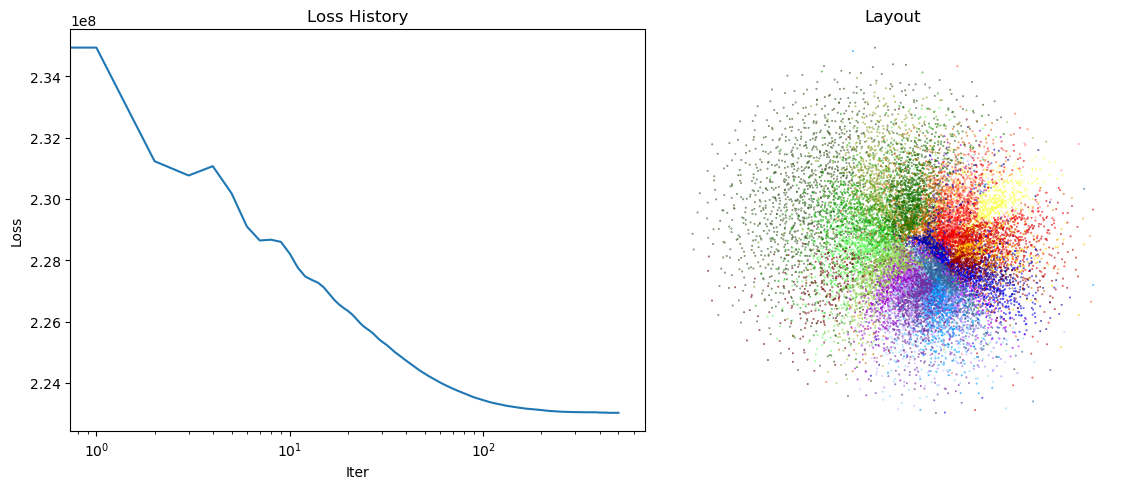

step: 502, Loss change ratio: 3.99e-05
stopping at step  501


[FDL Training]:   3%|▌                       | 501/20000 [2:18:41<89:58:07, 16.61s/it, loss=2.23e+8]

Total FDL training time: 8321.87s
train_fine time: 8.32e+03 s
train time: 1.49e+04 s


In [7]:
layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
             early_stop_check_steps = 100, 
             min_steps=200, 
             gcn_stop_threshold = GCN_STOP_THRESHOLD,
             fdl_stop_threshold = FDL_STOP_THRESHOLD,)

## GCNConv

In [ ]:
layout = ResGCN(feat_dims=[8,8, 8, 8, 8, DIMENSIONS], 
                A=A, edge_index=edge_index, edge_weight=edge_weight, node_colors=node_colors,
                lr=1e-1, GCN_class='GCNConv',)

cuda
latent radius 1.86


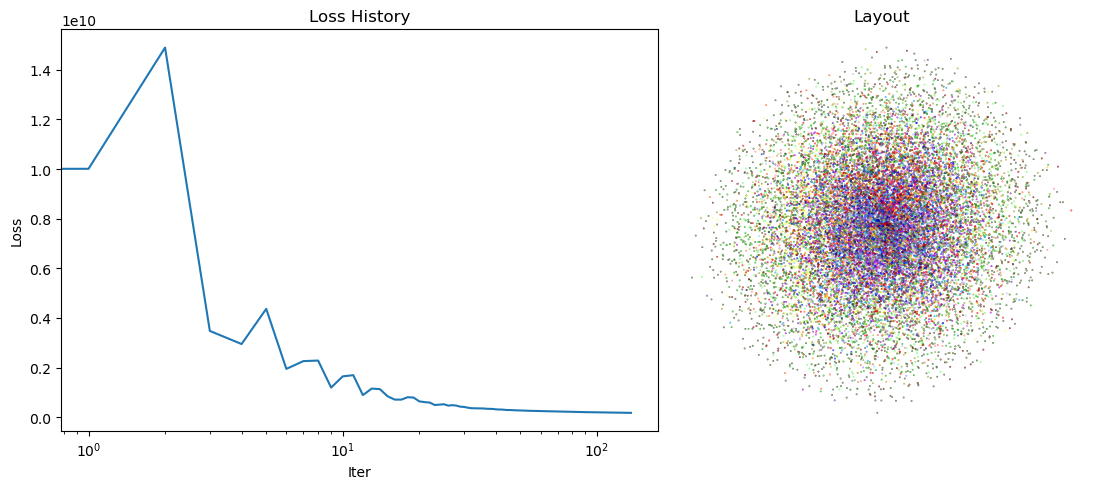

[GCN Training]:   7%|█▉                          | 137/2000 [24:06<5:21:26, 10.35s/it, loss=1.76e+8]

[GCN Training]:   7%|█▉                          | 137/2000 [24:16<5:30:01, 10.63s/it, loss=1.76e+8]


Training interrupted
train time: 1.46e+03 s


In [39]:
layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
             early_stop_check_steps = 100, 
             min_steps=200, 
             gcn_stop_threshold = GCN_STOP_THRESHOLD,
             fdl_stop_threshold = FDL_STOP_THRESHOLD,)

## 3D

In [7]:
# Space dimensions
DIMENSIONS = 3

# choose GCN small steps
MAX_GCN_STEPS = int(2e3)

# fine-tuning FDL steps. make large
MAX_FDL_STEPS = int(2e4)

# early stopping (lower = runs longer)
GCN_STOP_THRESHOLD = 5e-3
FDL_STOP_THRESHOLD = 2e-4

In [8]:
layout = ResGCN(feat_dims=[16,16, 16, 16, 16, DIMENSIONS], A=A, edge_index=edge_index, lr=1e-1, GCN_class='GATConv', c=2,
                node_colors=node_colors)

cuda
latent radius 1.86


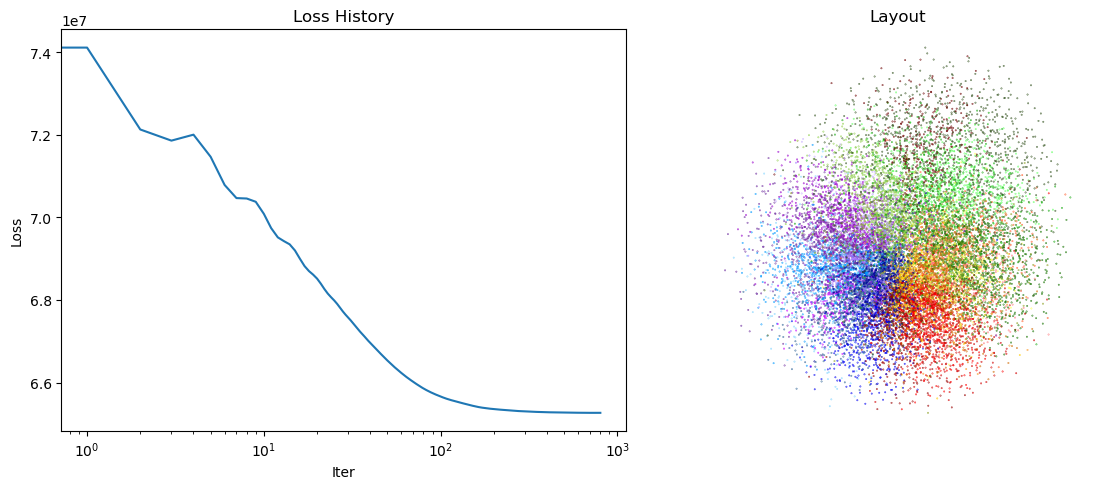

step: 802, Loss change ratio: 1.62e-05
stopping at step  801


[FDL Training]:   4%|▉                       | 801/20000 [2:09:25<51:42:12,  9.69s/it, loss=6.53e+7]

Total FDL training time: 7765.62s
train_fine time: 7.77e+03 s
train time: 1.07e+04 s


In [9]:
layout.train(gcn_steps=MAX_GCN_STEPS, fdl_steps=MAX_FDL_STEPS, 
             early_stop_check_steps = 100, 
             min_steps=200, 
             gcn_stop_threshold = GCN_STOP_THRESHOLD,
             fdl_stop_threshold = FDL_STOP_THRESHOLD,)

# 3d visualization

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt

In [5]:
X = pd.read_csv("/home/lyuzhuoqi/projects/periodical-clustering/data/2010s/journal_citation_net/neulay_results/3d/fdl_iter_00801.csv",
                header=None).to_numpy()

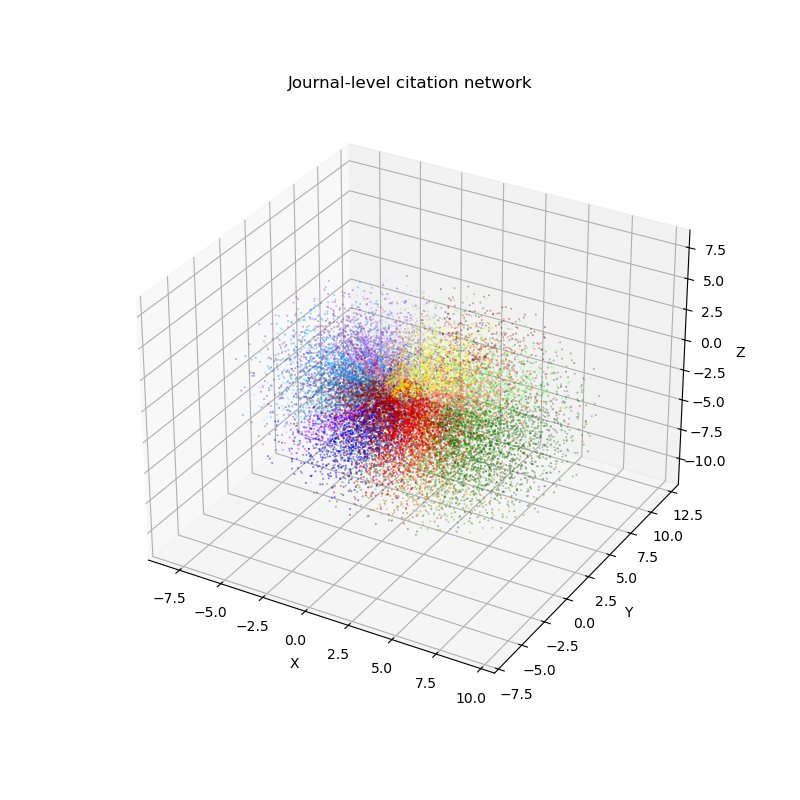

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=node_colors, s=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Journal-level citation network')

plt.show()